In [12]:
!pip install umap-learn

     |████████████████████████████████| 86 kB 7.1 MB/s eta 0:00:011
     |████████████████████████████████| 1.1 MB 30.2 MB/s eta 0:00:01
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82696 sha256=b5a0e7bb1898dc54723d36fe4426d0b4cb89935eaa823f46fba6b2dda3a7a8f3
  Stored in directory: /Users/niketpatel/Library/Caches/pip/wheels/f2/64/75/df601da9514261c8cb0830b9515d2b94b5a51f09ddeae92b9e
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52587 sha256=e4b7a44434834dcba18d23f1b6d96a467aa16a4098dd27ccf2dae7f0e1cdb11b
  Stored in directory: /Users/niketpatel/Library/Caches/pip/wheels/e4/0e/b5/07c0c231aacb04e5d1046fe7459bb27ea79f95b5edbe88e435
Successfully built umap-learn pynndescent


In [13]:
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.cluster import KMeans

import umap

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
np.random.seed(42)

# Load Dataset

In [3]:
data_path = '../features_3_sec.csv'
orig_df = pd.read_csv(data_path)

labels = orig_df['label']

features_df = orig_df.drop(['filename','length','label'], axis=1)
features_df.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,...,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767
1,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,...,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081
2,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,...,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122
3,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,...,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678
4,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,...,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694


# Feature normalization

In [16]:
features_scaled = StandardScaler().fit_transform(features_df)
scaled_df = pd.DataFrame(features_scaled)

scaled_df.head()

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,-0.487808,0.640520,-0.006624,0.235568,-0.566828,-0.572791,-0.493983,-0.009229,-0.518590,-0.367952,...,-0.750122,-0.299108,0.168647,-0.425137,-0.003423,-0.376938,-0.499464,-0.513562,0.128414,-0.291781
1,-0.403142,0.131835,-0.264944,-0.342134,-0.508798,-0.749862,-0.425382,-0.519010,-0.424118,-0.642268,...,0.457983,0.428544,-0.327031,-0.310040,-0.112125,-0.032083,-0.066593,1.011384,1.275780,0.056425
2,-0.361694,0.764491,0.016695,0.542195,-0.546245,-0.701852,-0.288365,-0.425734,-0.346190,-0.562723,...,0.585548,0.503695,0.428053,-0.648762,0.316311,-0.177372,0.109337,-0.046244,0.653907,-0.521458
3,-0.175714,0.205477,0.024885,-0.063820,-0.723482,-0.700599,-0.517344,-0.348881,-0.607665,-0.474804,...,-0.489524,-0.065309,0.062981,-0.649076,0.092384,-0.464121,-0.211882,-0.099501,0.865880,-0.544744
4,-0.485895,0.337521,0.181345,-0.272072,-0.756246,-0.774827,-0.538557,-0.572962,-0.667537,-0.683920,...,0.112417,-0.570609,0.856651,-0.167089,0.183265,-0.029476,-0.175130,-0.678995,0.276899,-0.606692


# UMAP

In [15]:
reducer = umap.UMAP(n_neighbors=50)

embedding = reducer.fit_transform(scaled_df)

<AxesSubplot:>

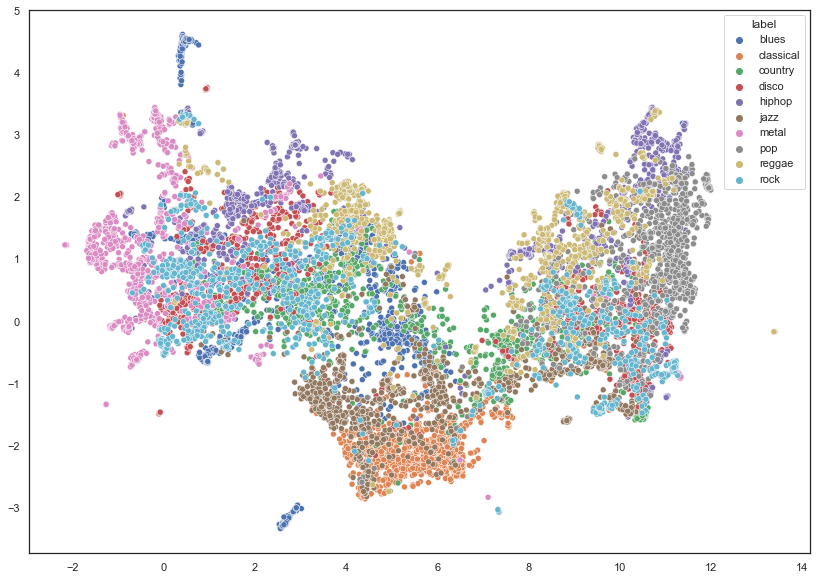

In [28]:
sns.scatterplot(embedding.T[0],
            embedding.T[1],
            hue = labels,
            cmap='tab10',
            linewidths=.01 
)

# Make Clustering

In [54]:
inertia_elbow = {}

for k in range(1,50):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(scaled_df)
    
    inertia_elbow[k] = kmeans.inertia_
    
inertia_elbow = pd.Series(inertia_elbow)

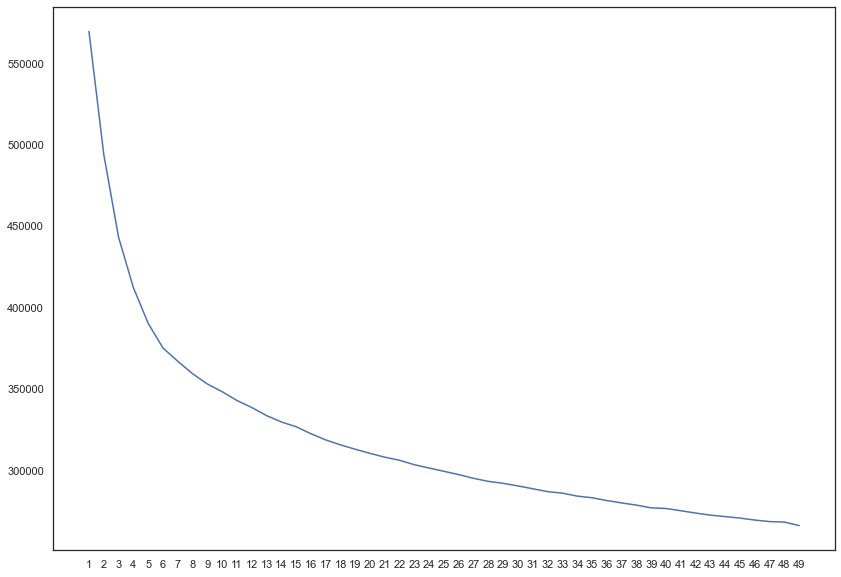

In [55]:
sns.lineplot(x = inertia_elbow.index, y = inertia_elbow)
plt.xticks(inertia_elbow.index)

plt.show()

In [67]:
kmeans = KMeans(n_clusters=10, random_state=42).fit(scaled_df)
kmeans_labels = kmeans.labels_.astype('object')

/Users/niketpatel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

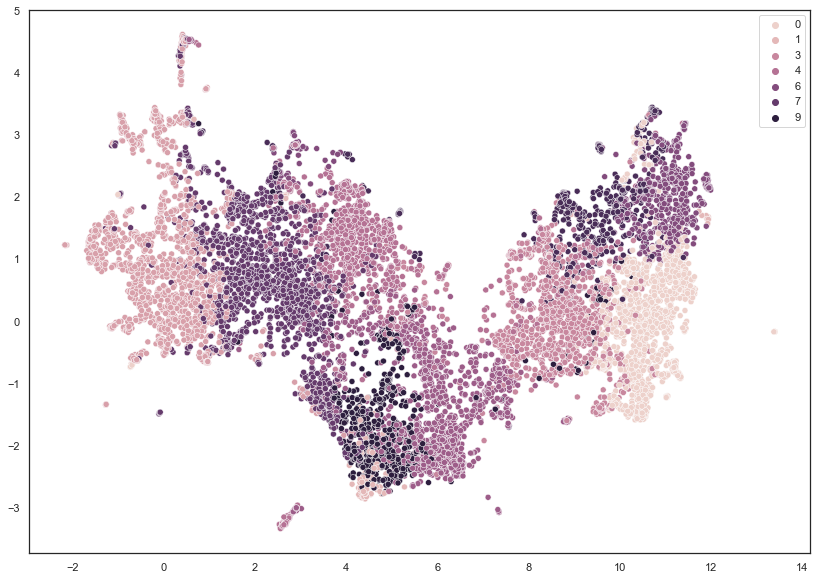

In [68]:
sns.scatterplot(embedding.T[0],
            embedding.T[1],
            hue = kmeans_labels,
            cmap='tab10',
            linewidths=.01 
)

# Assess Clusters

/Users/niketpatel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


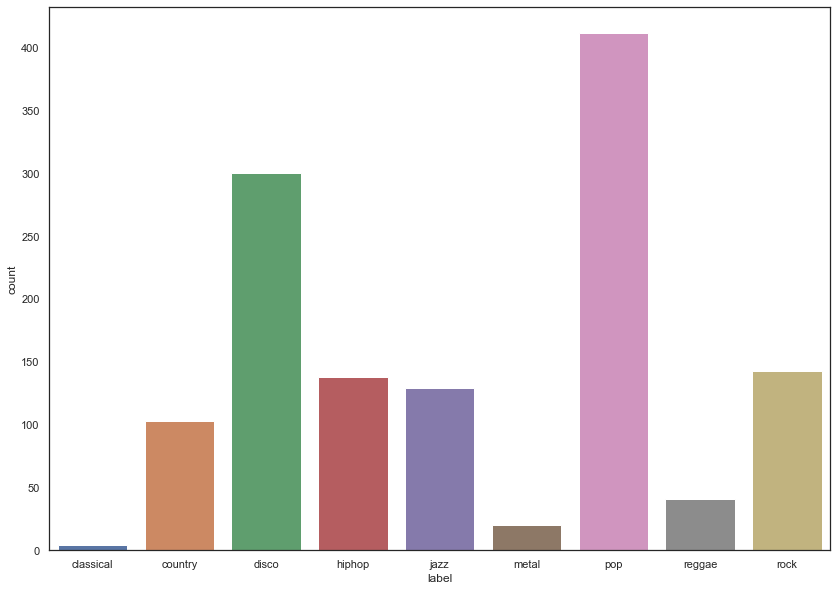

/Users/niketpatel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


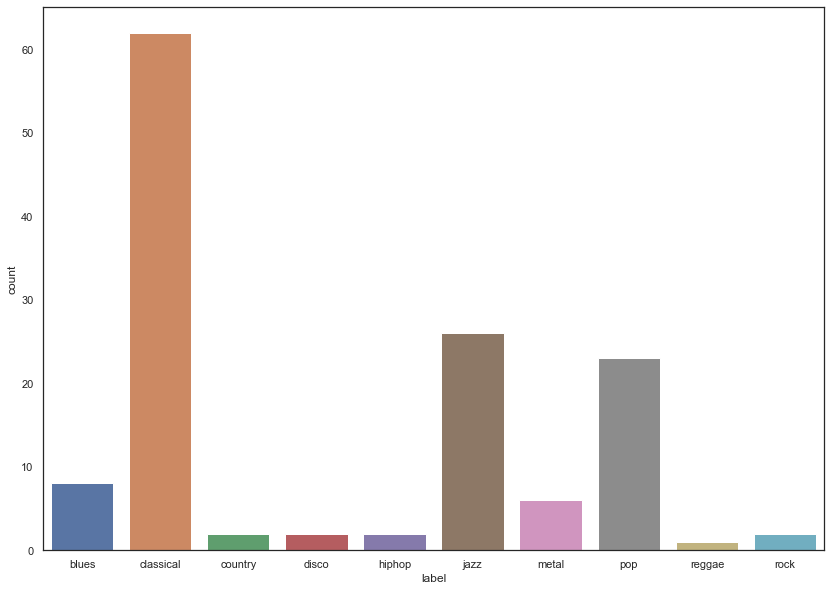

/Users/niketpatel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


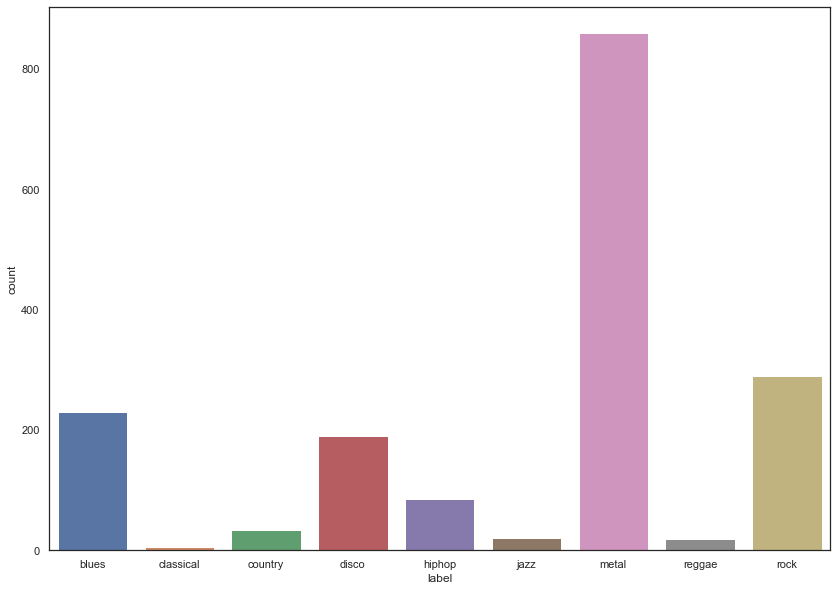

/Users/niketpatel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


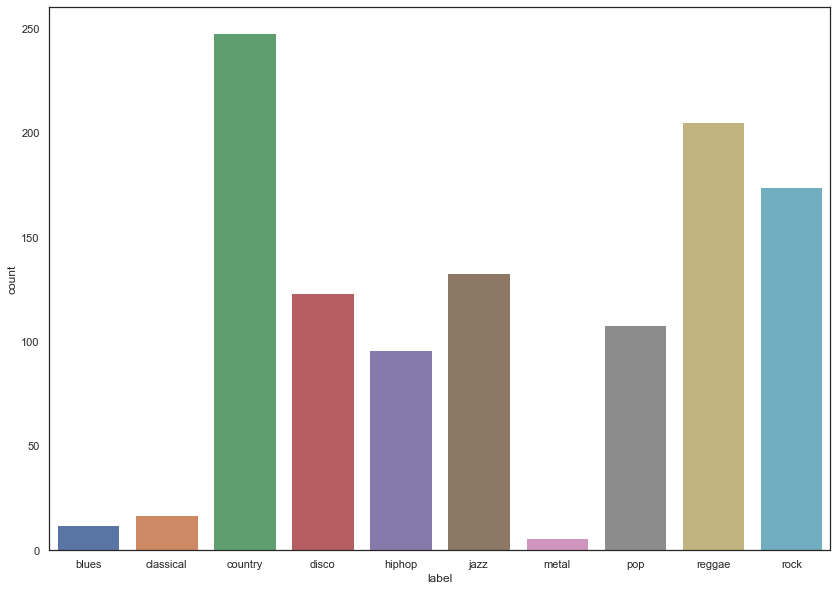

/Users/niketpatel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


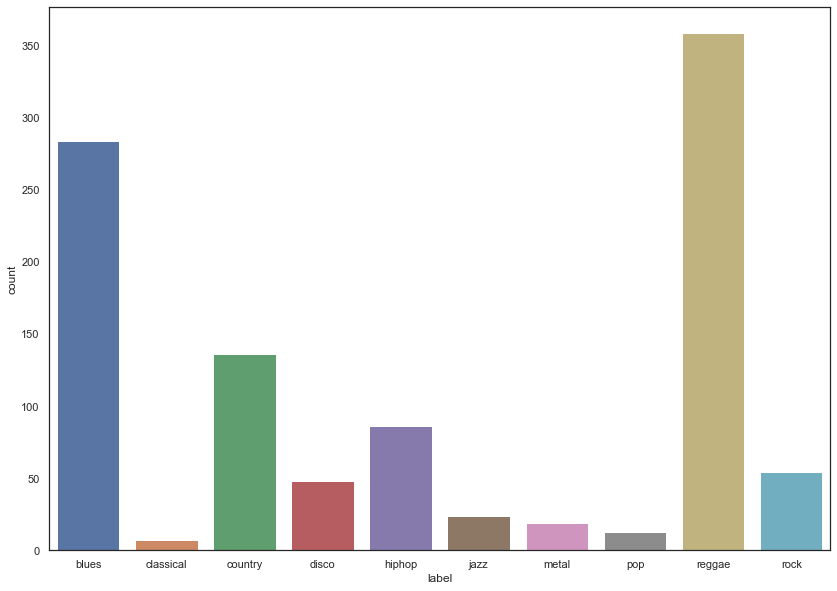

/Users/niketpatel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


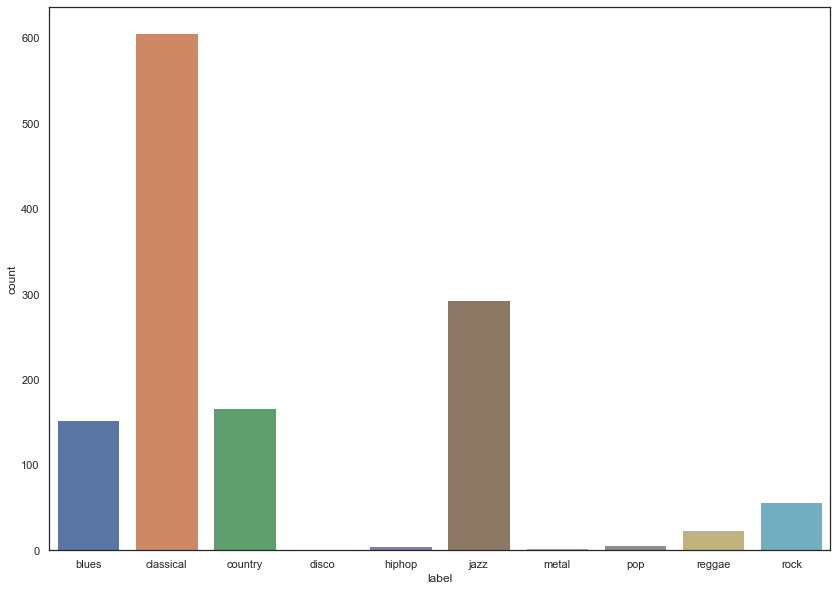

/Users/niketpatel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


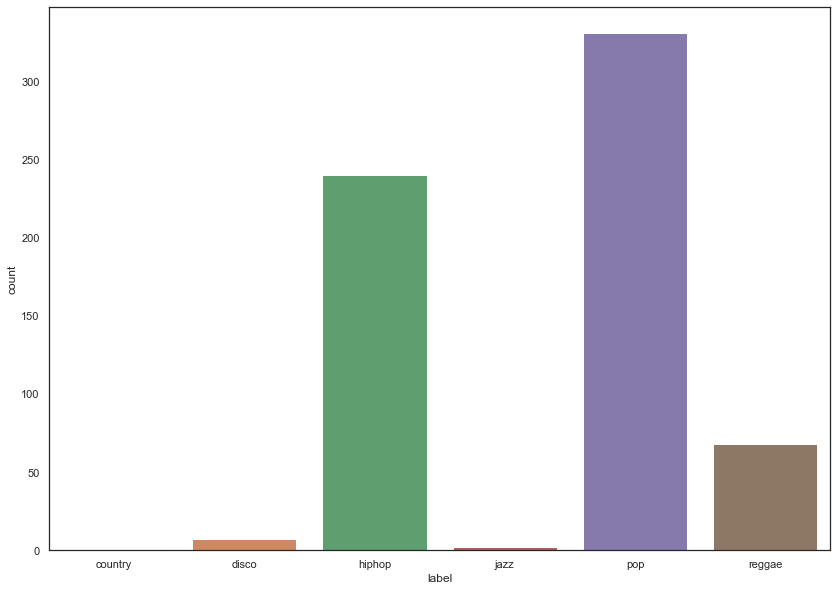

/Users/niketpatel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


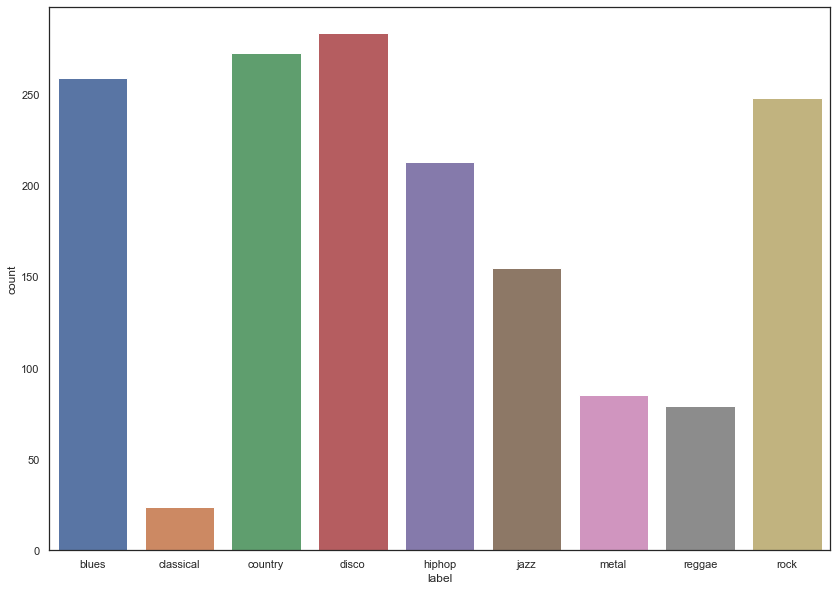

/Users/niketpatel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


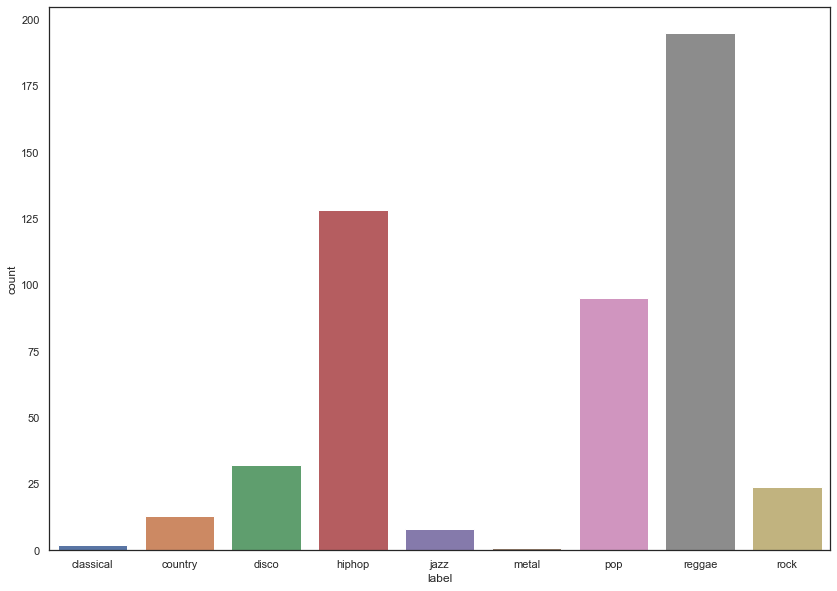

/Users/niketpatel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


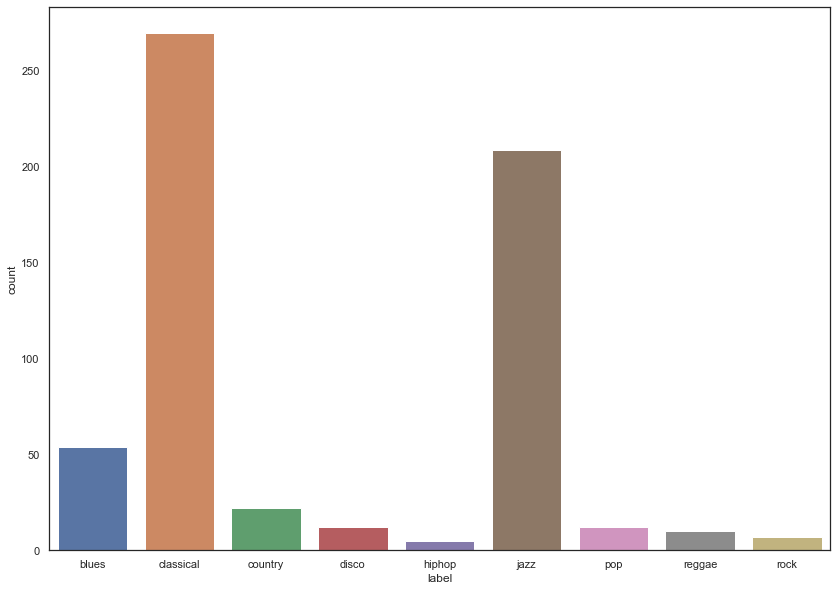

In [69]:
for k in range(0,10):
    sns.countplot(labels[kmeans_labels == [k]])
    plt.show()